In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import numpy as np
import random

In [32]:
from adjustText import adjust_text

In [9]:
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 469, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)
    outer_lines_fill = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=background_color, fill=True, zorder=-2)
    court_elements.append(outer_lines_fill)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [69]:
def plot_raw_shotchart(data_frame, title, mode="dark", assist_df=None, image_name=None):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 12))
    
    green = '#45B056'
    red = '#B04556'
    
    made_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 1]
    missed_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 0]
    
    paths = ax.scatter(
        x=made_shots.LOC_X,
        y=made_shots.LOC_Y,
        marker='o',
        c=green,
        s=100,
        alpha=0.8
    )
    
    paths = ax.scatter(
        x=missed_shots.LOC_X,
        y=missed_shots.LOC_Y,
        marker='x',
        c=red,
        s=100,
        alpha=0.8
    )
    
    if mode == 'dark':
        background_color="#363F48"
        font_color="#E8E8FF"
    else:
        background_color="#EBEBE8"
        font_color = "#454545"
    
    texts = []
    for index in range(len(data_frame)):
        item = data_frame.iloc[index]
        texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, s=item.ACTION_TYPE, fontsize=10, ha='center', va='center',
               bbox={'facecolor': '#EEEEEE', 'alpha': 0.75, 'edgecolor': 'black'}, zorder=0))
    
    # Changing court color
    #ax.set_facecolor('#FFFAFA')
    # Legend
    ax.scatter(x=230, y=380, s=400, marker='o', c=green, zorder=2)
    ax.text(x=220, y=380, s="Made", color=green, fontsize=18, ha='right', va='center')
    ax.scatter(x=230, y=360, s=400, marker='x', c=red, zorder=2)
    ax.text(x=220, y=360, s="Missed", color=red, fontsize=18, ha='right', va='center')

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)

    # Title
    plt.title(title, size=20)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, background_color=background_color)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)
    
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k'), expand_points=(1.5, 1.5))
    
    if image_name:
        fig.savefig(image_name, bbox_inches='tight')

In [11]:
from nba_api.stats.endpoints import ShotChartDetail
from nba_api.stats.static.players import find_players_by_full_name

In [12]:
player = find_players_by_full_name("LaMarcus Aldridge")
player_id = player[0]['id']

In [13]:
shot_chart = ShotChartDetail(team_id=0, player_id=player_id, season_nullable="2019-20", context_measure_simple='FGA')

In [14]:
shot_chart_df = shot_chart.get_data_frames()[0]

In [15]:
shot_chart_df.LOC_X = -shot_chart_df.LOC_X

In [20]:
aldrdige_memphis_df = shot_chart_df.loc[shot_chart_df.GAME_ID == '0021900450']

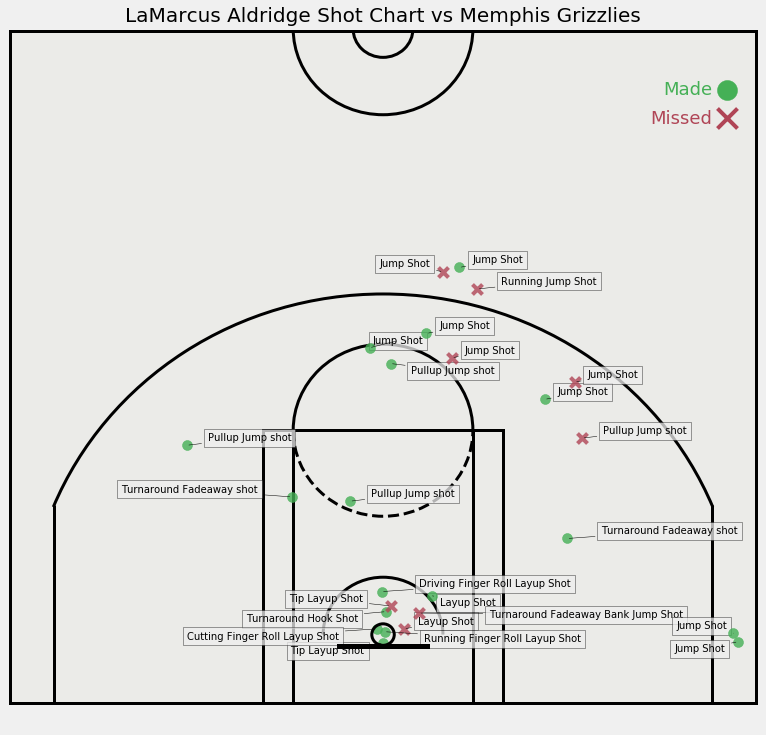

In [70]:
plot_raw_shotchart(data_frame=aldrdige_memphis_df, title='LaMarcus Aldridge Shot Chart vs Memphis Grizzlies', mode='light')